In [1]:
# you can call a function "on device"
import numpy as np
import cupy as cp
from cupyx import jit

@jit.rawkernel(device=True)
def do_a_thing(x, y):
    return (y, x)
    
@jit.rawkernel()
def do_more_things(x, y, size):
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    ntid = jit.gridDim.x * jit.blockDim.x
    for i in range(tid, size, ntid):
        (x[i], y[i]) = do_a_thing(x[i], y[i])

size = 10
x = cp.random.random(size, dtype=np.float32)
y = cp.random.random(size, dtype=np.float32)

print(x)
print(y)

do_more_things((128,),(1024,),(x, y, size))

print(x)
print(y)


/home/joel/.local/lib/python3.8/site-packages/cupyx/jit/_interface.py:161: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


[0.7578426  0.7681122  0.1761615  0.5355341  0.45468387 0.18167168
 0.03907524 0.18625654 0.5955092  0.00447233]
[0.2918105  0.96924305 0.07444187 0.07298744 0.37448078 0.02077719
 0.5541197  0.7205327  0.11233605 0.32354456]
[0.2918105  0.96924305 0.07444187 0.07298744 0.37448078 0.02077719
 0.5541197  0.7205327  0.11233605 0.32354456]
[0.7578426  0.7681122  0.1761615  0.5355341  0.45468387 0.18167168
 0.03907524 0.18625654 0.5955092  0.00447233]


In [2]:
# python float scalar type doesn't work, use numpy type
import numpy as np
import cupy as cp
from cupyx import jit

@jit.rawkernel()
def scalar_multiply(a, m, size):
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    ntid = jit.gridDim.x * jit.blockDim.x
    for i in range(tid, size, ntid):
        a[i] = a[i] * m

size = 5
a = cp.random.random(size, dtype=np.float32)

print(a)
scalar_multiply((128,),(1024,),(a, np.float32(5.0), size))
print(a)
scalar_multiply((128,),(1024,),(a, 5.0, size))
print(a)

[0.17383131 0.73825866 0.13147391 0.38758528 0.00451252]
[0.8691566  3.6912932  0.65736955 1.9379264  0.02256259]
[0. 0. 0. 0. 0.]


In [3]:
%%time
x = cp.random.random(10000000, dtype=np.float32) * 2

OutOfMemoryError: Out of memory allocating 40,000,000 bytes (allocated so far: 1,536 bytes).

In [4]:
%%time
y = cp.random.uniform(0, 2, 10000000, dtype=np.float32)

OutOfMemoryError: Out of memory allocating 40,000,000 bytes (allocated so far: 1,536 bytes).

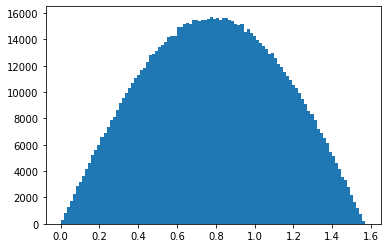

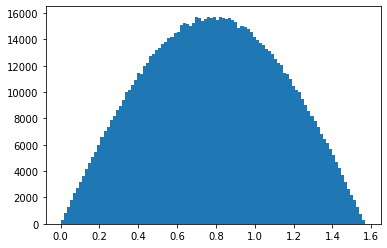

In [5]:
# i'm losing my mind
import numpy as np
import matplotlib.pyplot as plt

size = 1000000
x = np.arccos(2 * np.random.random(size) - 1) / 2
y = np.arccos(np.random.uniform(-1, 1, size))/2
plt.hist(x, bins=100);
plt.show()
plt.hist(y, bins=100);

In [6]:
# in-place
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from cupyx import jit

@jit.rawkernel()
def spherical_to_cartesian_raw(theta_z, phi_x, y, size) -> None:
    """in-place reuses the inputs."""
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    ntid = jit.gridDim.x * jit.blockDim.x
    for i in range(tid, size, ntid):
        y[i] = cp.sin(theta_z[i]) * cp.sin(phi_x[i])
        phi_x[i] = cp.sin(theta_z[i]) * cp.cos(phi_x[i])
        theta_z[i] = cp.cos(theta_z[i])
        
def spherical_to_cartesian(theta: cp.ndarray, phi: cp.ndarray) -> Tuple[cp.ndarray, cp.ndarray, cp.ndarray]:
    x = cp.sin(theta) * cp.cos(phi)
    y = cp.sin(theta) * cp.sin(phi)
    z = cp.cos(theta)
    return (x,y,z)

size = 1000000
# lambertian
phi_x = cp.random.uniform(0, 2 * np.pi, size, dtype=np.float32)
y = cp.empty(size, dtype=np.float32)
theta_z = cp.arccos(cp.random.uniform(-1, 1, size, dtype=np.float32)) / 2

plt.title('PHI')
plt.hist(phi_x.get(), bins=100)
plt.show()

plt.title('THETA')
plt.hist(theta_z.get(), bins=100)
plt.show()

# this way makes zero extra temporary columns
spherical_to_cartesian_raw((128,),(1024,),(theta_z, phi_x, y, size))

plt.title('X')
plt.hist(phi_x.get(), bins=100)
plt.show()

plt.title("Y")
plt.hist(y.get(), bins=100)
plt.show()

plt.title("Z")
plt.hist(theta_z.get(), bins=100)
plt.show()

# the other way

phi = cp.random.uniform(0, 2 * np.pi, size, dtype=np.float32)
theta = cp.arccos(cp.random.uniform(-1, 1, size, dtype=np.float32)) / 2

plt.title('PHI 2')
plt.hist(phi.get(), bins=100)
plt.show()

plt.title('THETA 2')
plt.hist(theta.get(), bins=100)
plt.show()

# this way makes two extra temporary columns
(x,y,z) = spherical_to_cartesian(theta, phi)

plt.title('X 2')
plt.hist(x.get(), bins=100)
plt.show()

plt.title("Y 2")
plt.hist(y.get(), bins=100)
plt.show()

plt.title("Z 2")
plt.hist(z.get(), bins=100)
plt.show()


/home/joel/.local/lib/python3.8/site-packages/cupyx/jit/_interface.py:161: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


OutOfMemoryError: Out of memory allocating 4,000,256 bytes (allocated so far: 12,002,304 bytes).

In [ ]:
# calculate histograms
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np

size = 1000000
x = cp.random.uniform(0, 1, size, dtype=np.float32)
plt.title('MatPlotLib histogram(X)')
plt.hist(x.get(), bins=100)
plt.show()

(hist, bin_edges) = cp.histogram(x, bins=100)
plt.title("CuPy histogram(X)")
plt.bar(x=0.5 * (bin_edges.get()[:-1] + bin_edges.get()[1:]), height=hist.get(), width = 0.01)

@cp.fuse()
def square_hist(y):
    print(type(y))
    print(y)
    return cp.sum((y // 0.2))

print(type(x))
(hist, bin_edges) = square_hist(x)
print(hist)
print(bin_edges)
plt.title("CuPy histogram(X^2)")
plt.bar(x=0.5 * (bin_edges.get()[:-1] + bin_edges.get()[1:]), height=hist.get(), width = 0.01)

# CUDA Histogram
uses shared memory

In [ ]:
import cupy as cp
import math
import matplotlib.pyplot as plt
import numpy as np
from cupyx import jit

@jit.rawkernel()
def histogram(input_data: cp.ndarray,
              global_histogram: cp.ndarray,
              size: np.int32,
              min_value: np.float32,
              bin_width: np.float32) -> None:
    """ input_data: cp.ndarray[np.float32]
        global_histogram: cp.ndarray[np.int32]
    """
    # Create a histogram for this block.  Size must match bins and threads.
    block_histogram = jit.shared_memory(np.int32, 128)

    # Alloc is not zeroed so do it.
    block_histogram[jit.threadIdx.x] = 0

    # Wait for all threads to set their zeros.
    jit.syncthreads()
    
    # Fill up the block-local histogram.
    # Adjacent threads get adjacent data:
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    # If there's more than one grid (not recommended) then do that too:
    ntid = jit.gridDim.x * jit.blockDim.x
    
    for i in range(tid, size, ntid):
        bucket_idx = int((input_data[i] - min_value) // bin_width)
        bucket_idx = int(min(max(bucket_idx, 0), 127)) # must match above
        jit.atomic_add(block_histogram, bucket_idx, 1)

    # Wait for all the threads to do it.
    jit.syncthreads()

    # Sum the block-local histograms into a global histogram.
    jit.atomic_add(global_histogram, jit.threadIdx.x, block_histogram[jit.threadIdx.x])

In [ ]:
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()
print(f"mempool.used_bytes {mempool.used_bytes()}")

size =100000000
bins = 128

threads_per_block = bins # because the threads write back
grid_size = (int(math.ceil(size / threads_per_block)), 1, 1)
block_size = (threads_per_block, 1, 1)
print(f"grid_size {grid_size}")
print(f"block_size {block_size}")

In [ ]:
epsilon = cp.finfo(np.float32).eps
# [0, pi/2)
y = cp.maximum(0.0, cp.arccos(cp.random.uniform(-1, 1, size, dtype=np.float32))/2 - epsilon) + 1

In [ ]:
print(cp.min(y))
print(cp.max(y))
print(y)
input_min = 1
input_max = np.pi/2 + 1
input_range = input_max - input_min
bin_width = input_range / bins
y_bin = cp.floor_divide(y - input_min, bin_width)
print(y_bin)
print(cp.max(y_bin))
print(cp.min(y_bin))

In [ ]:
%%time
# this is about 150us for 100M items (fast!)
h = cp.zeros(bins, dtype=np.int32)
histogram(grid_size, block_size, (y, h, size, np.float32(1), np.float32(np.pi/256)))

In [ ]:
%%time
# this is like 10ms for 100M items (slow!)
(h2,b2) = cp.histogram(y, bins=256)

In [ ]:
print(cp.sum(h))
print(h)
print(cp.min(h))

In [ ]:
f = plt.figure(figsize=[20, 10])
plt.plot(np.arange(bins), h.get(), snap=False)

In [ ]:
theta_freq = h.get()
theta_range = np.pi/2
theta_min = 0
theta_max = np.pi/2
theta_bins_rad = theta_range * np.arange(bins) / bins + theta_min
theta_bin_width_rad = theta_range / bins
theta_bucket_angle_steradians = np.array(
    list(map(lambda x: (np.cos((theta_range * x + theta_min) / bins)
                      - np.cos((theta_range * (x + 1) + theta_min) / bins)), range(bins),)))

photons_per_steradian_by_theta = theta_freq / theta_bucket_angle_steradians

fig = plt.figure(figsize=[15, 12])
axes = plt.subplot(projection="polar")
axes.set_theta_zero_location("N")
# mirror the data so it looks nice .. resulting in the weird bounds here
axes.set_thetamin(-theta_max * 180 / np.pi)
axes.set_thetamax(theta_max * 180 / np.pi)
axes.plot(
    theta_bins_rad,
    photons_per_steradian_by_theta,
    color="blue",
    snap=False
)
axes.plot(
    -theta_bins_rad,
    photons_per_steradian_by_theta,
    color="blue",
    snap=False
)
axes.set_xlabel("polar angle (theta) (degrees)")
axes.set_ylabel("photon count per ... ? (TODO: sr)")
plt.show()

In [ ]:
import cupy as cp
import numpy as np
x = cp.random.uniform(0, 1, 10000000, dtype=np.float32)

In [ ]:
%%time
y = cp.random.choice(x, 1000)
y2 = cp.random.choice(x, 1000)
y3 = cp.random.choice(x, 1000)
y4 = cp.random.choice(x, 1000)
y5 = cp.random.choice(x, 1000)
y6 = cp.random.choice(x, 1000)

In [ ]:
# selection performance

In [ ]:
import cupy as cp
import numpy as np
size = 100000000
x = cp.random.uniform(0, 1, size, dtype=np.float32)
selection_size = 1000
randidx = cp.random.randint(0, size, selection_size)
strideidx = cp.arange(0, size, size//selection_size + 1)

In [ ]:
%%timeit
y0 = x[randidx]
y1 = x[randidx]
y2 = x[randidx]
y3 = x[randidx]
y4 = x[randidx]
y5 = x[randidx]
xp = cp.column_stack((y0,y1,y2))
xd = cp.column_stack((y3,y4,y5))

In [ ]:
%%time
y = x[strideidx]

In [ ]:
first_few = cp.arange(selection_size)

In [ ]:
%%time
y = x[first_few]

Parallel strided selection

In [ ]:
import cupy as cp
import numpy as np
from cupyx import jit

@jit.rawkernel()
def select(i0, i1, i2, i3, i4, i5,
           s0, s1, s2, s3, s4, s5,
           selection_size, scale):
    idx = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    if idx < selection_size:
        i = idx * scale        
        s0[idx] = i0[i]
        s1[idx] = i1[i]
        s2[idx] = i2[i]
        s3[idx] = i3[i]
        s4[idx] = i4[i]
        s5[idx] = i5[i]

In [ ]:
size = np.int32(50000000)
x0 = cp.random.random(size, dtype=np.float32)
x1 = cp.random.random(size, dtype=np.float32)
x2 = cp.random.random(size, dtype=np.float32)
x3 = cp.random.random(size, dtype=np.float32)
x4 = cp.random.random(size, dtype=np.float32)
x5 = cp.random.random(size, dtype=np.float32)

selection_size = np.int32(1000)
scale = np.int32(size//selection_size)
y0 = cp.zeros(selection_size, dtype=np.float32)
y1 = cp.zeros(selection_size, dtype=np.float32)
y2 = cp.zeros(selection_size, dtype=np.float32)
y3 = cp.zeros(selection_size, dtype=np.float32)
y4 = cp.zeros(selection_size, dtype=np.float32)
y5 = cp.zeros(selection_size, dtype=np.float32)


select((32,),(32,),(x0, x1, x2, x3, x4, x5,
                    y0, y1, y2, y3, y4, y5,
                    selection_size, scale))

In [ ]:
%%timeit
# 375 us
select((32,),(32,),(x0, x1, x2, x3, x4, x5,
                    y0, y1, y2, y3, y4, y5,
                    selection_size, scale))

In [ ]:
%%time
## 1-2 ms
select((32,),(32,),(x0, x1, x2, x3, x4, x5,
                    y0, y1, y2, y3, y4, y5,
                    selection_size, scale))
xp = cp.column_stack((y0,y1,y2))
xd = cp.column_stack((y3,y4,y5))

---

### parallel selection and stacking

In [ ]:
import cupy as cp
import numpy as np
from cupyx import jit

@jit.rawkernel()
def select_and_stack(i0, i1, i2, i3, i4, i5,
                     p, d, # Nx3
                     selection_size, scale):
    idx = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    if idx < selection_size:
        s_i = idx * scale  
        p[(idx, 0)] = i0[s_i]
        p[(idx, 1)] = i1[s_i]
        p[(idx, 2)] = i2[s_i]
        d[(idx, 0)] = i3[s_i]
        d[(idx, 1)] = i4[s_i]
        d[(idx, 2)] = i5[s_i]

In [ ]:
size = np.int32(50000000)
x0 = cp.random.random(size, dtype=np.float32)
x1 = cp.random.random(size, dtype=np.float32)
x2 = cp.random.random(size, dtype=np.float32)
x3 = cp.random.random(size, dtype=np.float32)
x4 = cp.random.random(size, dtype=np.float32)
x5 = cp.random.random(size, dtype=np.float32)

selection_size = np.int32(1000)
scale = np.int32(size//selection_size)
p = cp.zeros((selection_size, 3), dtype=np.float32)
d = cp.zeros((selection_size, 3), dtype=np.float32)

select_and_stack((32,),(32,),(x0, x1, x2, x3, x4, x5,
                              p, d,
                              selection_size, scale))

In [ ]:
%%timeit
select_and_stack((32,),(32,),(x0, x1, x2, x3, x4, x5,
                              p, d,
                              selection_size, scale))

In [ ]:
print(p)

In [ ]:
import k3d
import numpy as np
plot = k3d.plot()
plot += k3d.vectors(p.get(), d.get())
plot += k3d.vectors(p.get(), d.get())
plot.display()

In [ ]:
import cupy as cp
import numpy as np
size = np.int32(100000000)
x0 = cp.random.random(size, dtype=np.float32)


In [ ]:
%%timeit
x0.size

In [ ]:
%%timeit
len(x0)

In [ ]:
%%timeit
x0.shape[0]

---

### curand in an elementwise kernel with a preallocated inoutvar and no return

In [ ]:
import cupy as cp
import numpy as np

make_rand = cp.ElementwiseKernel(
    in_params = 'raw uint64 seed',
    out_params = 'float32 z',
    preamble = """
    #include <curand.h>
    #include <curand_kernel.h>
    """,
    loop_prep = """
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    curandState state;
    curand_init(seed, idx, 0, &state);
    """,
    operation = """
    z = curand_uniform(&state);
    """,
    no_return = True)

size = 16
z = cp.empty(size, dtype=np.float32)
seed = np.random.default_rng().integers(1, np.iinfo(np.uint64).max, dtype=np.uint64)
make_rand(seed, z)
print(z)

In [ ]:
size = 10000000
z = cp.empty(size, dtype=np.float32)

In [ ]:
%%time
# 157 us
make_rand(seed, z)

In [ ]:
print(z)

---

In [ ]:
from optics_cuda import *
import numpy as np

propagate = cp.ElementwiseKernel(
    in_params = 'raw uint64 seed, raw float32 absorption, raw float32 height, raw float32 size',
    out_params = 'float32 r_x, float32 r_y, float32 r_z, float32 ez_x, float32 ez_y, float32 ez_z, bool alive',
    preamble = """
    #include <curand.h>
    #include <curand_kernel.h>""",
    loop_prep = """
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    curandState state;
    curand_init(seed, idx, 0, &state);""",
    operation = """
    if (!alive) continue;
    if (ez_z < 0) {
        alive = false;
        continue;
    }
    r_x = r_x + height * ez_x / ez_z;
    r_y = r_y + height * ez_y / ez_z;
    r_z = height;
    
    bool done_reflecting = false;
    while (!done_reflecting) {
        if (r_x < -size / 2) {
            r_x = -size - r_x;
            ez_x *= -1;
            // er_x *= -1; // no more persistent perpendicular
            if (curand_uniform(&state) < absorption) break;
        } else if (r_x > size / 2) {
            r_x = size - r_x;
            ez_x *= -1;
            // er_x *= -1;
            if (curand_uniform(&state) < absorption) break;
        } else if (r_y < -size / 2) {
            r_y = -size - r_y;
            ez_y *= -1;
            // er_y *= -1;
            if (curand_uniform(&state) < absorption) break;
        } else if (r_y > size / 2) {
            r_y = size - r_y;
            ez_y *= -1;
            // er_y *= -1;
            if (curand_uniform(&state) < absorption) break;
        }
        if (r_x >= -size / 2 && r_x <= size / 2 && r_y >= -size / 2 && r_y <= size / 2)
            done_reflecting = true;
    }
    if (!done_reflecting) {
        alive = false;
    }
    """,
    no_return = True)

lightbox_height = np.float32(400)
lightbox_size = np.float32(400)
photon_count = np.int32(25000000)
source_size = np.float32(10)
photons = LambertianSource(source_size, source_size).make_photons(photon_count)

source_sample = photons.sample()

print(f" R X: {photons.r_x}")
print(f" R Y: {photons.r_y}")
print(f" R Z: {photons.r_z}")
print(f"EZ X: {photons.ez_x}")
print(f"EZ Y: {photons.ez_y}")
print(f"EZ Z: {photons.ez_z}")
print(f"ALIVE: {photons.alive}")

seed = np.random.default_rng().integers(1, np.iinfo(np.uint64).max, dtype=np.uint64)
absorption = np.float32(0.1)





In [ ]:
%%time
propagate(seed, absorption, lightbox_height, lightbox_size,
         photons.r_x, photons.r_y, photons.r_z,
         photons.ez_x, photons.ez_y, photons.ez_z,
         photons.alive)

In [ ]:
%time
# 3 us, how can that be?
photons.prune()
#photons.r_x = cp.compress(photons.alive, photons.r_x)
#photons.r_y = cp.compress(photons.alive, photons.r_y)
#photons.r_z = cp.compress(photons.alive, photons.r_z)
#photons.ez_x = cp.compress(photons.alive, photons.ez_x)
#photons.ez_y = cp.compress(photons.alive, photons.ez_y)
#photons.ez_z = cp.compress(photons.alive, photons.ez_z)
#photons.alive = cp.compress(photons.alive, photons.alive)

In [ ]:

print(f" R X: {photons.r_x}")
print(f" R Y: {photons.r_y}")
print(f" R Z: {photons.r_z}")
print(f"EZ X: {photons.ez_x}")
print(f"EZ Y: {photons.ez_y}")
print(f"EZ Z: {photons.ez_z}")
print(f"ALIVE: {photons.alive}")
print(f"count: {len(photons.alive)}")

In [ ]:
from viz_cuda import *
source_box = [-source_size/2, source_size/2, -source_size/2, source_size/2, 0]
lightbox_box = [-lightbox_size/2, lightbox_size/2, -lightbox_size/2, lightbox_size/2, lightbox_height]
diff_sample = photons.sample()
plot_3d([source_sample, diff_sample], ray_lengths=[100, 100],
        boxes=[source_box, lightbox_box], labels=['LED','diffuser'], colors=[0xffff00, 0x00ffff])

---

In [ ]:
import cupy as cp
import numpy as np

size = 10000000
x = cp.ones(size, dtype=np.float32)
b = cp.random.default_rng().integers(2,size=size).astype(bool)
print(x)
print(len(x))
y = x[b]
print(y)
print(len(y))

In [ ]:
%%timeit
y = x[b]

In [ ]:
x[b]=0

In [ ]:
print(x)

In [ ]:
a = cp.argsort(x)
print(a)

In [ ]:
%%timeit
a = cp.argsort(x)

In [ ]:
z = cp.compress(b, x)
print(z)
print(len(z))

In [ ]:
%%timeit
z = cp.compress(b, x)

---

In [ ]:
import numpy as np
import cupy as cp

xn = np.ones(1000, dtype=np.float32)
xc = np.ones(1000, dtype=np.float32)

In [ ]:
%%timeit
xn * 2

In [ ]:
%%timeit
xc * 2

In [ ]:
#profiler = Profiler()
#profiler.start()
#
#donothing(x, y)
#
#session = profiler.stop()
#profile_renderer = ConsoleRenderer(unicode=True, color=True, show_all=True, time='percent_of_total')
#print(profile_renderer.render(session))

---

In [ ]:
import cupy as cp
import numpy as np
from cupyx import jit
import math
from pyinstrument import Profiler
from pyinstrument.renderers import ConsoleRenderer

@cp.fuse()
def donothing_fused(x, y):
    return x+y
#    if x:
#        return x
#    else:
#        return y

@cp.fuse()
def trick_fused(x,y):
    cp.add(x,y,out=y)
#    if x:
#        cp.add(x,False,out=y)
    
@jit.rawkernel()
def rawnothing_jit(x,y):
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    ntid = jit.gridDim.x * jit.blockDim.x
    for i in range(tid, size, ntid):
        y[i] = x[i] + y[i]
#        if x[i]:
#            y[i] = x[i]

donothing_elementwise = cp.ElementwiseKernel(
    in_params='bool x',
    out_params = 'bool y',
    operation = """
    y = x + y
    //    if (x) y = x
    """,
    no_return = True)

donothing_elementwise_raw = cp.ElementwiseKernel(
    in_params='raw uint8 x',
    out_params = 'raw uint8 y',
    operation = """
    y[i] = x[i] + y[i]
    //    if (x[i]) y[i] = x[i]
    """,
    no_return = True)

really_raw = cp.RawKernel(r'''
extern "C" __global__
void really_raw(const bool* x1, bool* x2, unsigned int N) {
    int tid = blockDim.x * blockIdx.x + threadIdx.x;
    if (tid < N) {
        x2[tid] = x1[tid] + x2[tid];
        //        if (x1[tid]) x2[tid] = x1[tid];
    }
}
''', 'really_raw')

size = 30000000

In [ ]:
x = cp.random.randint(2, size=size).astype(bool)
y = cp.zeros(size, dtype=bool)
print(cp.sum(x))
print(cp.sum(y))

profiler = Profiler()
profiler.start()

iter = 2000
for i in range(iter):
    trick_fused(x, y)
    cp.cuda.Device().synchronize()

session = profiler.stop()
profile_renderer = ConsoleRenderer(unicode=True, color=True, show_all=True)
print(profile_renderer.render(session))
print(f"duration microsec: {1e6*session.root_frame().time()/iter}")

print(cp.sum(x))
print(cp.sum(y))

In [ ]:
x = cp.random.randint(2, size=size).astype(bool)
y = cp.zeros(size, dtype=bool)
y2 = cp.zeros(size, dtype=bool)
print(cp.sum(x))
print(cp.sum(y))
print(cp.sum(y2))

profiler = Profiler()
profiler.start()

iter = 2000
for i in range(iter):
    y2 = donothing_fused(x, y)
    cp.cuda.Device().synchronize()
cp.cuda.Device().synchronize()

session = profiler.stop()
profile_renderer = ConsoleRenderer(unicode=True, color=True, show_all=True)
print(profile_renderer.render(session))
print(f"duration microsec: {1e6*session.root_frame().time()/iter}")


print(cp.sum(x))
print(cp.sum(y))
print(cp.sum(y2))
print(len(x))
print(len(y))
print(len(y2))

In [ ]:
x = cp.random.randint(2, size=size).astype(bool)
y = cp.zeros(size, dtype=bool)
print(cp.sum(y))

profiler = Profiler()
profiler.start()

iter = 2000
for i in range(iter):
    rawnothing_jit((1024,),(1024,),(x,y))
    cp.cuda.Device().synchronize()

session = profiler.stop()
profile_renderer = ConsoleRenderer(unicode=True, color=True, show_all=True)
print(profile_renderer.render(session))
print(f"duration microsec: {1e6*session.root_frame().time()/iter}")

print(cp.sum(x))
print(cp.sum(y))
print(cp.sum(y2))

In [ ]:
x = cp.random.randint(2, size=size).astype(bool)
y = cp.zeros(size, dtype=bool)
print(cp.sum(x))
print(cp.sum(y))

profiler = Profiler()
profiler.start()

iter = 2000
for i in range(iter):
    donothing_elementwise(x,y)
cp.cuda.Device().synchronize()

session = profiler.stop()
profile_renderer = ConsoleRenderer(unicode=True, color=True, show_all=True)
print(profile_renderer.render(session))
print(f"duration microsec: {1e6*session.root_frame().time()/iter}")

print(cp.sum(x))
print(cp.sum(y))
print(cp.sum(y2))

In [ ]:
x = cp.random.randint(2, size=size, dtype=np.uint8)
y = cp.zeros(size, dtype=np.uint8)
print(cp.sum(x))
print(cp.sum(y))


profiler = Profiler()
profiler.start()

iter = 2000
for i in range(iter):
    donothing_elementwise_raw(x,y,size=size)
cp.cuda.Device().synchronize()

session = profiler.stop()
profile_renderer = ConsoleRenderer(unicode=True, color=True, show_all=True)
print(profile_renderer.render(session))
print(f"duration microsec: {1e6*session.root_frame().time()/iter}")

print(cp.sum(x))
print(cp.sum(y))

In [ ]:
x = cp.random.randint(2, size=size).astype(bool)
print(x)
print(cp.sum(x))
y = cp.zeros(size, dtype=bool)
print(y)
print(cp.sum(y))

block_size = 1024 # max
grid_size = int(math.ceil(size/block_size))

profiler = Profiler()
profiler.start()

iter = 1000
for i in range(iter):
    really_raw((grid_size,),(block_size,),(x,y, np.uint32(size)))
cp.cuda.Device().synchronize()

session = profiler.stop()
profile_renderer = ConsoleRenderer(unicode=True, color=True, show_all=True)
print(profile_renderer.render(session))
print(f"duration microsec: {1e6*session.root_frame().time()/iter}")

print(cp.sum(x))
print(cp.sum(y))

In [ ]:
x = cp.random.randint(2, size=size).astype(bool)
print(x)
print(cp.sum(x))
y = cp.zeros(size, dtype=bool)
print(y)
print(cp.sum(y))

profiler = Profiler()
profiler.start()

iter = 2000
for i in range(iter):
    y = cp.where(x, x, y)
cp.cuda.Device().synchronize()

session = profiler.stop()
profile_renderer = ConsoleRenderer(unicode=True, color=True, show_all=True)
print(profile_renderer.render(session))
print(f"duration microsec: {1e6*session.root_frame().time()/iter}")

print(cp.sum(x))
print(cp.sum(y))
print(len(x))
print(len(y))

In [ ]:
x = cp.random.randint(2, size=size).astype(bool)
print(x)
print(cp.sum(x))
y = cp.zeros(size, dtype=bool)
print(y)
print(cp.sum(y))

profiler = Profiler()
profiler.start()

iter = 2000
for i in range(iter):
    cp.place(y, x, True)
cp.cuda.Device().synchronize()

session = profiler.stop()
profile_renderer = ConsoleRenderer(unicode=True, color=True, show_all=True)
print(profile_renderer.render(session))
print(f"duration microsec: {1e6*session.root_frame().time()/iter}")

print(cp.sum(x))
print(cp.sum(y))
print(len(x))
print(len(y))

In [ ]:
x = cp.random.randint(2, size=size).astype(bool)
print(x)
print(cp.sum(x))
y = cp.zeros(size, dtype=bool)
print(y)
print(cp.sum(y))

profiler = Profiler()
profiler.start()

iter = 2000
for i in range(iter):
    cp.copyto(y, x)
cp.cuda.Device().synchronize()

session = profiler.stop()
profile_renderer = ConsoleRenderer(unicode=True, color=True, show_all=True)
print(profile_renderer.render(session))
print(f"duration microsec: {1e6*session.root_frame().time()/iter}")

print(cp.sum(x))
print(cp.sum(y))
print(len(x))
print(len(y))

In [ ]:
x = cp.random.randint(2, size=size).astype(bool)

profiler = Profiler()
profiler.start()

iter = 2000
for i in range(iter):
    cp.count_nonzero(x)
cp.cuda.Device().synchronize()

session = profiler.stop()
profile_renderer = ConsoleRenderer(unicode=True, color=True, show_all=True)
print(profile_renderer.render(session))
print(f"duration microsec: {1e6*session.root_frame().time()/iter}")

In [ ]:
x = cp.random.randint(2, size=size).astype(bool)

profiler = Profiler()
profiler.start()

iter = 2000
for i in range(iter):
    cp.sum(x)
cp.cuda.Device().synchronize()

session = profiler.stop()
profile_renderer = ConsoleRenderer(unicode=True, color=True, show_all=True)
print(profile_renderer.render(session))
print(f"duration microsec: {1e6*session.root_frame().time()/iter}")

In [ ]:
size = 30000000

profiler = Profiler()
profiler.start()

iter = 2000
for i in range(iter):
    x = cp.random.random(size, dtype=float32)
cp.cuda.Device().synchronize()

session = profiler.stop()
profile_renderer = ConsoleRenderer(unicode=True, color=True, show_all=True)
print(profile_renderer.render(session))
print(f"duration microsec: {1e6*session.root_frame().time()/iter}")

---

In [ ]:
# compute simple reflections without conditionals
import cupy as cp
import matplotlib.pyplot as plt

x = cp.linspace(-5,5,101) # position of ray at top surface relative to center

reflection_count = cp.abs(cp.round(x))
plt.figure(figsize=[10,5])
plt.plot(x.get(), reflection_count.get())
plt.title("reflection count")

absorption = 0.1
photon_survival = cp.power((1-absorption), reflection_count)
plt.figure(figsize=[10,5])
plt.plot(x.get(), photon_survival.get())
plt.title("photon survival")

# where does the ray appear? (https://en.wikipedia.org/wiki/Triangle_wave)
new_position = cp.abs(cp.mod(x - 0.5, 2) - 1) - 0.5
plt.figure(figsize=[10,5])
plt.plot( x.get(), new_position.get())
plt.title("new position")

# with what direction? https://en.wikipedia.org/wiki/Square_wave
#new_direction = 2 *( 2 * cp.floor((x + 0.5) / period) - cp.floor(2 * (x + 0.5) / period)) + 1
new_direction = 1 - 2 * cp.mod(reflection_count,2)
plt.figure(figsize=[10,5])
plt.plot(x.get(), new_direction.get())
plt.title("new direction")

In [ ]:
import cupy as cp
import math
import matplotlib.pyplot as plt

# an example

r_x = 0
r_y = 0
r_z = 0
# 45 degrees should reflect once and emerge at the center with ez_x reversed
ez_x = 2.2
ez_z = 1
ez_y = 0
n = math.sqrt(ez_x **2 + ez_y ** 2 + ez_z ** 2)
ez_x = ez_x/n
ez_y = ez_y/n
ez_z = ez_z/n

print(f"r_x {r_x}")
print(f"r_y {r_y}")
print(f"r_z {r_z}")
print(f"ez_x {ez_x}")
print(f"ez_y {ez_y}")
print(f"ez_z {ez_z}")


absorption = 0.1
height = 0.04 # cm
width = 0.04 # cm

# assume all the photons come from the center because it's close to being correct and simplifies the math.

r_x_tmp = r_x + height * ez_x/ez_z
r_y_tmp = r_y + height * ez_y/ez_z
print(f"r_x_tmp {r_x_tmp}")
print(f"r_y_tmp {r_y_tmp}")

r_x_box_widths = r_x_tmp/width
print(f"r_x_box_widths {r_x_box_widths}")
r_y_box_widths = r_y_tmp/width
print(f"r_y_box_widths {r_y_box_widths}")




reflection_count_x = cp.abs(cp.round(r_x_box_widths))
print(f"reflection_count_x {reflection_count_x}")

new_position_x = 2 * cp.abs(cp.mod(r_x_box_widths - 0.5, 2) - 1) - 1
print(f"new_position_x {new_position_x}")
new_direction_x = ez_x * (1 - 2 * cp.mod(reflection_count_x, 2))
print(f"new_direction_x {new_direction_x}")

reflection_count_y = cp.abs(cp.round(r_y_box_widths))
print(f"reflection_count_y {reflection_count_y}")
new_position_y = 2 * cp.abs(cp.mod(r_y_box_widths - 0.5, 2) - 1) - 1
print(f"new_position_y {new_position_y}")
new_direction_y = ez_y * (1 - 2 * cp.mod(reflection_count_y, 2))
print(f"new_direction_y {new_direction_y}")

total_reflection_count = reflection_count_x + reflection_count_y
print(f"total_reflection_count {total_reflection_count}")
photon_survival = cp.power((1-absorption), total_reflection_count)
print(f"photon_survival {photon_survival}")
alive = cp.logical_and(cp.less(cp.random.random(1), photon_survival), cp.greater(ez_z, 0))
print(f"alive {alive}")
